In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import json
import munch
import sde_jump as eqn
import options as opts
from pricers import PureJumpPricer
from generate_data import create_dataset
import global_constants as constants
from utils import load_config

In [9]:
# load config and data
sde_name = "GBMJ"
option_name = "Swap"
dim = 1
epsilon = 1.0 # corresponded to the paper in Berner 2020.
config = load_config(sde_name, option_name, dim)
initial_mode = config.eqn_config.initial_mode
kernel_type = config.net_config.kernel_type
sde = getattr(eqn, config.eqn_config.sde_name)(config)
option = getattr(opts, config.eqn_config.option_name)(config)

samples = config.eqn_config.sample_size
time_steps = config.eqn_config.time_steps
dims = config.eqn_config.dim
dataset_path = f"./dataset/{sde_name}_{option_name}_{dim}_{time_steps}"
create_dataset(sde_name, option_name, dim, 100)
dataset = tf.data.experimental.load(
    dataset_path,
    element_spec=(
        tf.TensorSpec(shape=(samples, time_steps + 1, 1)),
        tf.TensorSpec(shape=(samples, time_steps + 1, dims)), # x
        tf.TensorSpec(shape=(samples, time_steps, dims)), # dw
        tf.TensorSpec(shape=(samples, time_steps, dims)), # h
        tf.TensorSpec(shape=(samples, time_steps, dims)), # z
        tf.TensorSpec(shape=(samples, time_steps + 1, 4)), # degree = 3
    ),
)
dataset = dataset.batch(config.eqn_config.batch_size)
test_dataset = dataset.take(10) 
train_dataset = dataset.skip(10)

(TensorSpec(shape=(50, 101, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 101, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 101, 4), dtype=tf.float32, name=None))


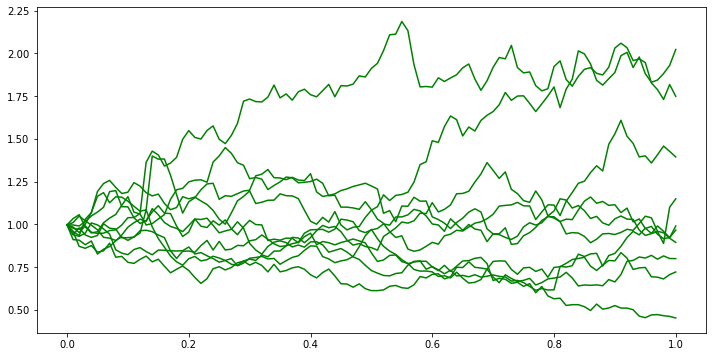

[0.02862229 0.36578643 1.2186475  1.1799977 ]


In [12]:
# visualize the data simulated from the factor
for element in train_dataset.take(5):
    t, x, _, _,_, u = element
t_np, x_np, u_np = t.numpy(), x.numpy(), u.numpy()
plt.figure(figsize=(12, 6))
idx=6
M = 10
plt.plot(t_np[idx,:M,:,0].T, x_np[idx, :M, :, 0].T,'g',label='$X_t$')
plt.show()
print(u_np[idx, 0, 0, :])

In [5]:
# train it
checkpoint_path = f"./checkpoint/{sde_name}_{option_name}_{dim}"
pricer = PureJumpPricer(sde, option, config)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=tf.math.sqrt(0.1), patience=6)
optimizer = tf.keras.optimizers.Adam(learning_rate=config.net_config.lr, epsilon=1e-6)
pricer.compile(optimizer=optimizer)
# tf.config.run_functions_eagerly(True)
pricer.fit(x=dataset, epochs=30, callbacks=[lr_schedule])
pricer.no_net.save_weights(checkpoint_path)
# split dataset
for element in test_dataset.take(5):
    t, x, _, _, _ , u_hat = element
y_pred = pricer((t, x, u_hat))
y_exact = option.exact_price(t, x, u_hat)
y_pred, y_exact = y_pred.numpy(), y_exact.numpy()

def evaluate(y1, y2):
    idx=-1
    t = (np.abs(y1[:,:,:idx] - y2[:,:,:idx]))
    return np.mean(t), np.std(t)
mean, std = evaluate(y_pred, y_exact)
print(mean)
# assert mean <= 0.1 
# assert std <= 0.1
# print("test passed")

Epoch 1/30
100/100 [==============================] - 162s 1s/step - loss: 6.4889 - loss interior: 6.4375 - loss terminal: 0.0514
Epoch 2/30
100/100 [==============================] - 115s 1s/step - loss: 2.6538 - loss interior: 2.6433 - loss terminal: 0.0106
Epoch 3/30
100/100 [==============================] - 115s 1s/step - loss: 1.9279 - loss interior: 1.9247 - loss terminal: 0.0032
Epoch 4/30
100/100 [==============================] - 115s 1s/step - loss: 1.7047 - loss interior: 1.7038 - loss terminal: 8.8161e-04
Epoch 5/30
100/100 [==============================] - 115s 1s/step - loss: 1.6922 - loss interior: 1.6914 - loss terminal: 7.7518e-04
Epoch 6/30
100/100 [==============================] - 115s 1s/step - loss: 1.6888 - loss interior: 1.6880 - loss terminal: 7.6897e-04
Epoch 7/30
100/100 [==============================] - 115s 1s/step - loss: 1.6910 - loss interior: 1.6902 - loss terminal: 8.1200e-04
Epoch 8/30
100/100 [==============================] - 115s 1s/step - loss:

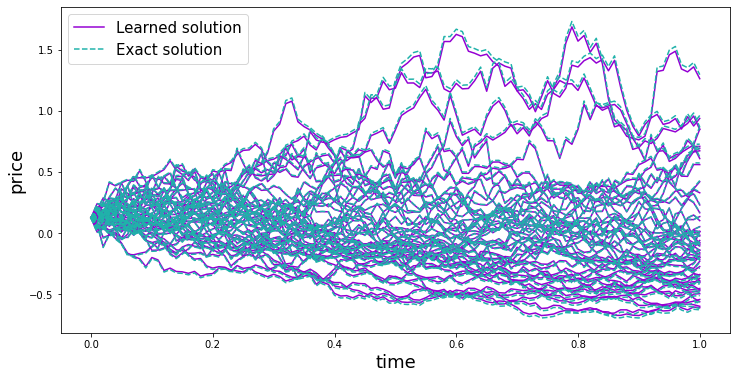

[0.03621654 0.5224855  1.0847569  0.95464724]


In [22]:
for element in train_dataset.take(5):
    t, x, _, _,_, u = element
t_np, x_np, u_np = t.numpy(), x.numpy(), u.numpy()
y_pred = pricer((t, x, u))
y_exact = option.exact_price(t,x,u)
y_p_np = y_pred.numpy()
y_e_np = y_exact.numpy()
plt.figure(figsize=(12, 6))
idx=26
M = 50
plt.plot(t_np[idx,:1,:,0].T, y_p_np[idx, :1, :, 0].T,'darkviolet',label='Learned solution')
plt.plot(t_np[idx,:1,:,0].T, y_e_np[idx, :1, :, 0].T,'--',color='lightseagreen',label='Exact solution')
plt.plot(t_np[idx,1:M,:,0].T, y_p_np[idx, 1:M, :, 0].T,'darkviolet')
plt.plot(t_np[idx,1:M,:,0].T, y_e_np[idx, 1:M, :, 0].T,'--',color='lightseagreen')

plt.xlabel('time', fontdict={"size": 18})
plt.ylabel('price', fontdict={"size": 18})
#plt.title(fr'm={u_hat[-1]: 2f}, r={u_hat[0]: 2f}, $\theta$={u_hat[1]: 2f},$\kappa$={u_hat[2]: 2f}， $\sigma$={u_hat[3]: 2f}, $\rho$={u_hat[4]: 2f}')# , $\rho$={u_hat[2]: 2f}')
plt.legend(prop={"size": 15})
plt.show()
print(u_np[idx, 0, 0, :])

In [2]:
# load config and data
sde_name = "GBMJ"
option_name = "Swap"
dim = 1
epsilon = 1.0 # corresponded to the paper in Berner 2020.
config = load_config(sde_name, option_name, dim)
initial_mode = config.eqn_config.initial_mode
kernel_type = config.net_config.kernel_type
sde = getattr(eqn, config.eqn_config.sde_name)(config)
option = getattr(opts, config.eqn_config.option_name)(config)

samples = config.eqn_config.sample_size
time_steps = config.eqn_config.time_steps
dims = config.eqn_config.dim
dataset_path = f"./dataset/{sde_name}_{option_name}_{dim}_{time_steps}"
create_dataset(sde_name, option_name, dim, 100)
dataset = tf.data.experimental.load(
    dataset_path,
    element_spec=(
        tf.TensorSpec(shape=(samples, time_steps + 1, 1)),
        tf.TensorSpec(shape=(samples, time_steps + 1, dims)), # x
        tf.TensorSpec(shape=(samples, time_steps, dims)), # dw
        tf.TensorSpec(shape=(samples, time_steps, dims)), # h
        tf.TensorSpec(shape=(samples, time_steps, dims)), # z
        tf.TensorSpec(shape=(samples, time_steps + 1, 4)), # degree = 3
    ),
)
dataset = dataset.batch(config.eqn_config.batch_size)
test_dataset = dataset.take(10) 
train_dataset = dataset.skip(10)

(TensorSpec(shape=(50, 101, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 101, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 100, 1), dtype=tf.float32, name=None), TensorSpec(shape=(50, 101, 4), dtype=tf.float32, name=None))


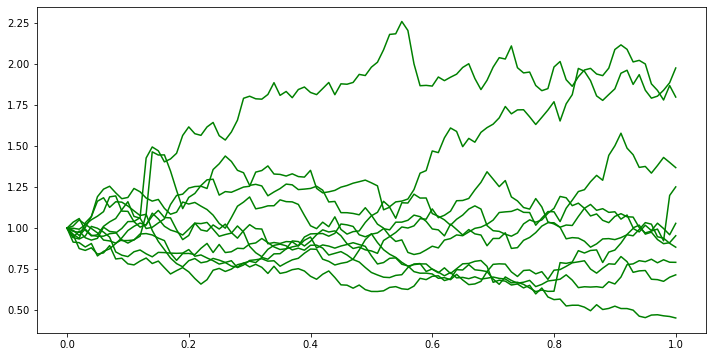

[0.0208029  0.3616918  1.0932076  0.91330063]


In [3]:
# visualize the data simulated from the factor
for element in train_dataset.take(5):
    t, x, _, _,_, u = element
t_np, x_np, u_np = t.numpy(), x.numpy(), u.numpy()
plt.figure(figsize=(12, 6))
idx=6
M = 10
plt.plot(t_np[idx,:M,:,0].T, x_np[idx, :M, :, 0].T,'g',label='$X_t$')
plt.show()
print(u_np[idx, 0, 0, :])

In [4]:
# train it
checkpoint_path = f"./checkpoint/{sde_name}_{option_name}_{dim}"
pricer = PureJumpPricer(sde, option, config)
lr_schedule = tf.keras.callbacks.ReduceLROnPlateau(monitor="loss", factor=tf.math.sqrt(0.1), patience=6)
optimizer = tf.keras.optimizers.Adam(learning_rate=config.net_config.lr, epsilon=1e-6)
pricer.compile(optimizer=optimizer)
# tf.config.run_functions_eagerly(True)
pricer.fit(x=dataset, epochs=30, callbacks=[lr_schedule])
pricer.no_net.save_weights(checkpoint_path)
# split dataset
for element in test_dataset.take(5):
    t, x, _, _, _ , u_hat = element
y_pred = pricer((t, x, u_hat))
y_exact = option.exact_price(t, x, u_hat)
y_pred, y_exact = y_pred.numpy(), y_exact.numpy()

def evaluate(y1, y2):
    idx=-1
    t = (np.abs(y1[:,:,:idx] - y2[:,:,:idx]))
    return np.mean(t), np.std(t)
mean, std = evaluate(y_pred, y_exact)
print(mean)
# assert mean <= 0.1 
# assert std <= 0.1
# print("test passed")

Epoch 1/30
100/100 [==============================] - 163s 1s/step - loss: 18.8976 - loss interior: 18.7881 - loss terminal: 0.1095
Epoch 2/30
100/100 [==============================] - 115s 1s/step - loss: 11.9710 - loss interior: 11.9504 - loss terminal: 0.0205
Epoch 3/30
100/100 [==============================] - 115s 1s/step - loss: 11.9224 - loss interior: 11.9025 - loss terminal: 0.0200
Epoch 4/30
100/100 [==============================] - 115s 1s/step - loss: 11.8793 - loss interior: 11.8601 - loss terminal: 0.0192
Epoch 5/30
100/100 [==============================] - 115s 1s/step - loss: 11.8049 - loss interior: 11.7872 - loss terminal: 0.0177
Epoch 6/30
100/100 [==============================] - 115s 1s/step - loss: 11.7954 - loss interior: 11.7777 - loss terminal: 0.0177
Epoch 7/30
100/100 [==============================] - 116s 1s/step - loss: 11.7692 - loss interior: 11.7517 - loss terminal: 0.0175
Epoch 8/30
100/100 [==============================] - 115s 1s/step - loss: 1

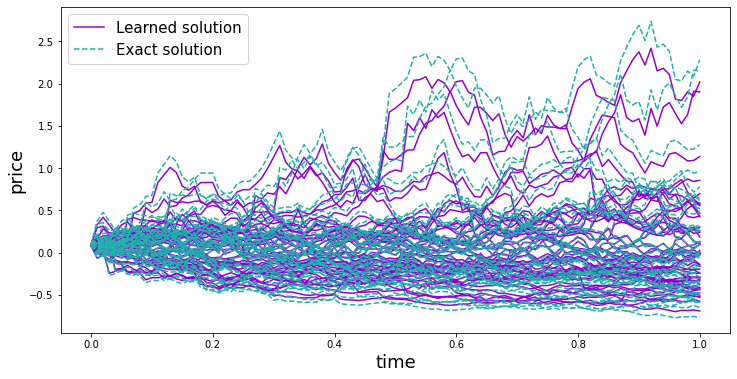

[0.04978206 0.53302    1.0985624  0.95915294]


In [8]:
for element in train_dataset.take(5):
    t, x, _, _, _, u = element
t_np, x_np, u_np = t.numpy(), x.numpy(), u.numpy()
y_pred = pricer((t, x, u))
y_exact = option.exact_price(t,x,u)
y_p_np = y_pred.numpy()
y_e_np = y_exact.numpy()
plt.figure(figsize=(12, 6))
idx=29
M = 50
plt.plot(t_np[idx,:1,:,0].T, y_p_np[idx, :1, :, 0].T,'darkviolet',label='Learned solution')
plt.plot(t_np[idx,:1,:,0].T, y_e_np[idx, :1, :, 0].T,'--',color='lightseagreen',label='Exact solution')
plt.plot(t_np[idx,1:M,:,0].T, y_p_np[idx, 1:M, :, 0].T,'darkviolet')
plt.plot(t_np[idx,1:M,:,0].T, y_e_np[idx, 1:M, :, 0].T,'--',color='lightseagreen')

plt.xlabel('time', fontdict={"size": 18})
plt.ylabel('price', fontdict={"size": 18})
#plt.title(fr'm={u_hat[-1]: 2f}, r={u_hat[0]: 2f}, $\theta$={u_hat[1]: 2f},$\kappa$={u_hat[2]: 2f}， $\sigma$={u_hat[3]: 2f}, $\rho$={u_hat[4]: 2f}')# , $\rho$={u_hat[2]: 2f}')
plt.legend(prop={"size": 15})
plt.show()
print(u_np[idx, 0, 0, :])